In [249]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [250]:
shoes = pd.read_csv('shoes_data.csv')
shoes.head()

,name,brand,price,article_number,color,shoe_height,sole_thickness,producing_country,brand_country,shoe_size,season,style,closure_type,upper_material,heel_height,rating_value,rating_count
0,Женские кроссовки TENDANCE,TENDANCE,11940,HC2216-1,черный,"7,5 см",4 см,КИТАЙ,ФРАНЦИЯ,37,Демисезонная (весна-лето-осень),"Casual, Уличный спорт",шнуровка,натуральная кожа,NaN,NaN,NaN
1,Женские кроссовки TENDANCE,TENDANCE,12990,1663-01,белый,7 см,"5,5 см",КИТАЙ,ФРАНЦИЯ,37,Демисезонная (осень-зима),"Уличный спорт, Casual",шнуровка,натуральная кожа,NaN,5.0,122.0
2,Женские кеды FILA FX-100 DEMI W,FILA,6000,FX-10,DEMI,"7,5 см","3,5 см",КИТАЙ,ИТАЛИЯ,37,Демисезонная (осень-зима-весна),NaN,шнуровка,искусственный материал,NaN,4.5,4.0
3,Женские кроссовки MAISON DAVID,MAISON DAVID,11290,N196A-01A,черный,7 см,"3,3 см",КИТАЙ,ФРАНЦИЯ,37,Демисезонная (осень-зима),"Casual, Уличный спорт",шнуровка,натуральная кожа,NaN,5.0,2.0
4,Женские высокие кроссовки FILA NEBULA PUFFY WN...,FILA,9190,NEBUL,PUFFY,"11,5 см","4,5 см",КИТАЙ,ИТАЛИЯ,37,Демисезонная (осень-зима-весна),Уличный спорт,шнуровка,текстиль,NaN,5.0,139.0


Выбранный Target признак - цена пары обуви.
Выведем основную информацию по таблице:

In [251]:
shoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3093 entries, 0 to 3092
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               3093 non-null   object 
 1   brand              3093 non-null   object 
 2   price              3093 non-null   int64  
 3   article_number     3093 non-null   object 
 4   color              3093 non-null   object 
 5   shoe_height        3069 non-null   object 
 6   sole_thickness     3087 non-null   object 
 7   producing_country  3093 non-null   object 
 8   brand_country      3080 non-null   object 
 9   shoe_size          3093 non-null   int64  
 10  season             3093 non-null   object 
 11  style              2663 non-null   object 
 12  closure_type       2250 non-null   object 
 13  upper_material     3093 non-null   object 
 14  heel_height        2379 non-null   object 
 15  rating_value       2105 non-null   float64
 16  rating_count       2105 

Очевидно, что артикул пары обуви и размер не влияют на цену, поэтому этот столбец можно убрать

In [252]:
shoes = shoes.drop(['article_number', 'shoe_size'], axis=1)

Из датасета видим, что признаки высота shoe_height, sole_thickness и heel_height числовые, но хранятся строками, что неудобно.
Распарсим и приведем к числам

In [253]:
shoes['shoe_height'] = shoes['shoe_height'].str.replace('см', '').str.replace(',', '.').astype(float)
shoes['sole_thickness'] = shoes['sole_thickness'].str.replace('см', '').str.replace(',', '.').astype(float)
shoes['heel_height'] = shoes['heel_height'].str.replace('см', '').str.replace(',', '.').astype(float)

Теперь разберемся с NaN значениями.
Для столбцов shoe_height, sole_thickness, rating_value, rating_count сосчитаем среднее значение и заполним пропуски.
Для высоты каблука заполним NaN значениями 0

In [254]:
shoes['shoe_height'].fillna(shoes['shoe_height'].mean(), inplace=True)
shoes['sole_thickness'].fillna(shoes['sole_thickness'].mean(), inplace=True)
shoes['rating_value'].fillna(shoes['rating_value'].mean(), inplace=True)
shoes['rating_count'].fillna(shoes['rating_count'].mean(), inplace=True)
shoes['heel_height'].fillna(0, inplace=True)

Распарсим значения в столбце season, извлечем более четкую информацию о сезонности обуви, созадв новые столбцы

In [255]:
shoes['season'] = shoes['season'].str.lower()
shoes["season_spring"] = shoes["season"].str.contains("весна", case=False).astype(int)
shoes["season_summer"] = shoes["season"].str.contains("лето", case=False).astype(int)
shoes["season_autumn"] = shoes["season"].str.contains("осень", case=False).astype(int)
shoes["season_winter"] = shoes["season"].str.contains("зима", case=False).astype(int)
shoes = shoes.drop('season', axis=1)

Аналогично разделим style на отдельные категории, предварительно заполнив NaN значения

In [256]:
most_common_style = shoes['style'].mode()[0]
shoes['style'] = shoes['style'].fillna(most_common_style)

shoes['style'] = shoes['style'].str.lower()
shoes["style_casual"] = shoes["style"].str.contains("casual", case=False).astype(int)
shoes["style_sport"] = shoes["style"].str.contains("уличный спорт", case=False).astype(int)
shoes["style_urban"] = shoes["style"].str.contains("городской рок", case=False).astype(int)
shoes["style_glamour"] = shoes["style"].str.contains("гламур", case=False).astype(int)
shoes["style_ethnic"] = shoes["style"].str.contains("этнический", case=False).astype(int)
shoes["style_elegant"] = shoes["style"].str.contains("bcbg (элегантный, классический)", case=False).astype(int)
shoes["style_conceptual_art"] = shoes["style"].str.contains("концептуальный арт", case=False).astype(int)
shoes = shoes.drop(['color', 'brand_country', 'upper_material', 'producing_country'], axis=1)


shoes = shoes.drop('style', axis=1)

/var/folders/_m/dd0v7x6n0zv23642lfd7kf4x_jnm3c/T/ipykernel_25051/729978252.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  shoes["style_elegant"] = shoes["style"].str.contains("bcbg (элегантный, классический)", case=False).astype(int)


Распарсим название обуви и вытащим оттуда shoes_types

In [257]:
shoes_types = ['кроссовки', 'ботинки', 'лоферы', 'кеды', 'челси', 'полусапоги', 'дерби', 'казаки', 'ботильоны', 'угги', 'дутики' ]
shoes['shoes_type'] = shoes['name'].apply(lambda x: next((type for type in shoes_types if type in x.lower()), None) or "none")
shoes.shoes_type.value_counts()

shoes_type
ботинки       813
none          450
ботильоны     399
кеды          333
челси         268
лоферы        217
кроссовки     174
полусапоги    150
дутики         95
дерби          88
угги           83
казаки         23
Name: count, dtype: int64

Построим гистогрумму для типов обуви

Text(0.5, 1.0, 'Distribution of shoes_type')

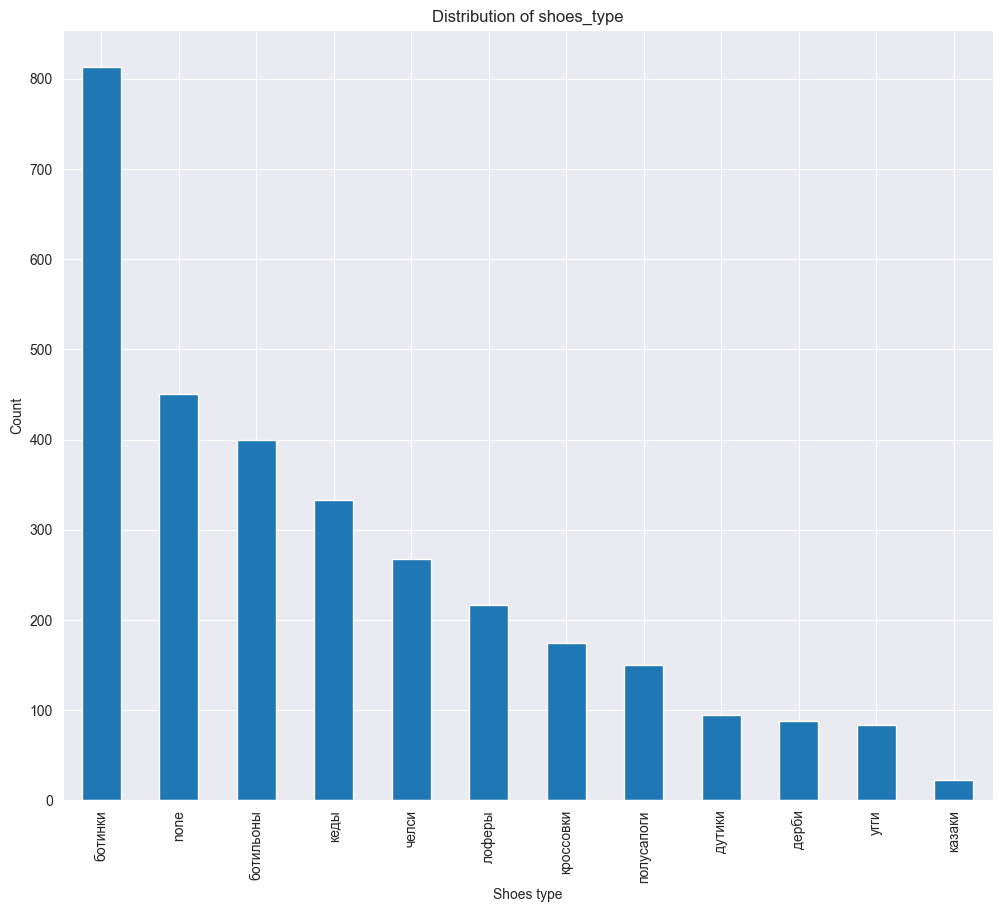

In [258]:
shoes_types_counts = shoes['shoes_type'].value_counts()

plt.figure(figsize=(12, 10))
shoes_types_counts.plot(kind='bar')
plt.xlabel('Shoes type')
plt.ylabel('Count')
plt.title("Distribution of shoes_type")

Типы обуви, которые появляются редко, объединим в other_shoes_type

In [259]:
shoes['shoes_type'] = shoes['shoes_type'].apply(lambda x: x if shoes['shoes_type'].value_counts()[x] > 150 else 'others_shoes_type')
shoes = shoes.drop("name", axis = 1)

После преобразования стало:

Text(0.5, 1.0, 'Distribution of shoes_type')

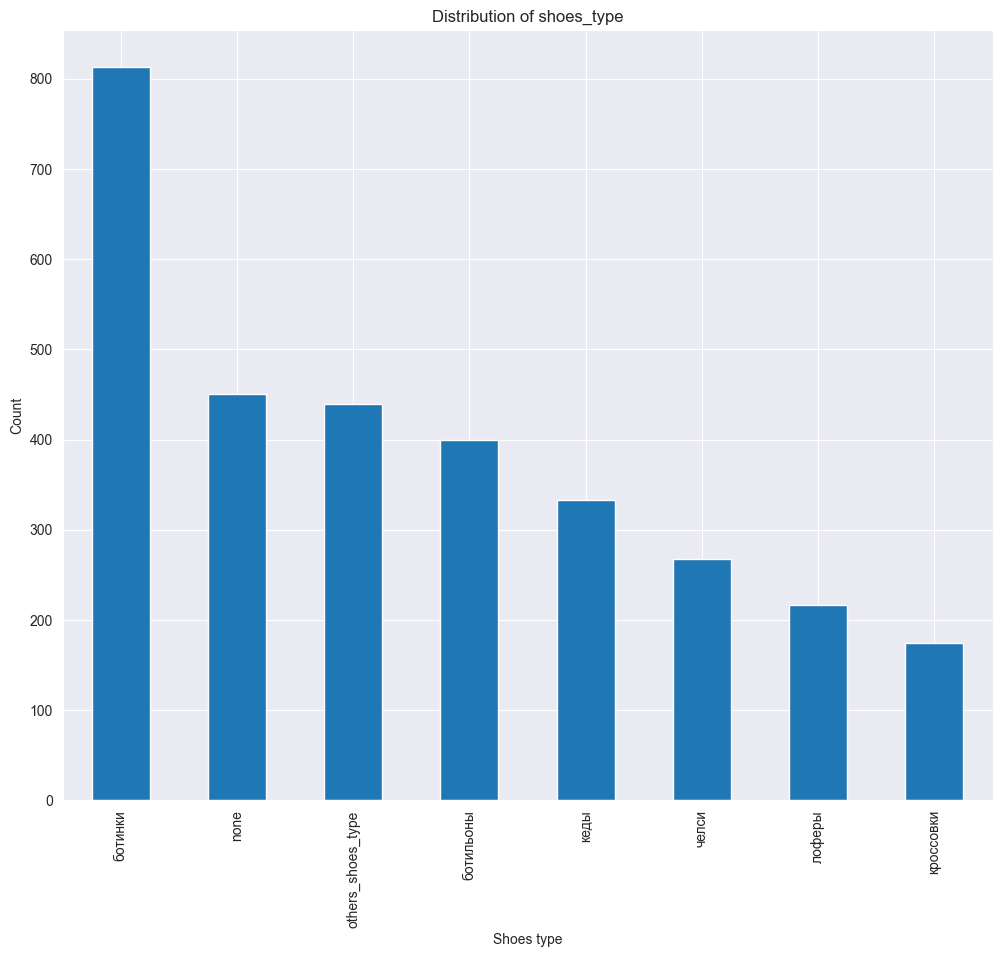

In [260]:
shoes_types_counts = shoes['shoes_type'].value_counts()

plt.figure(figsize=(12, 10))
shoes_types_counts.plot(kind='bar')
plt.xlabel('Shoes type')
plt.ylabel('Count')
plt.title("Distribution of shoes_type")

NaN знчения в столбцах категориальных переменных заполним самым часто встречающимся и сосчитаем количество уникальных значений

In [261]:
category_features = ['brand', 'closure_type']
for feature in category_features:
    most_common_value = shoes   [feature].value_counts().index[0]
    shoes[feature] = shoes[feature].fillna(most_common_value)
    print(feature, " unique = ", shoes[feature].nunique())


brand  unique =  54
closure_type  unique =  7


Text(0.5, 1.0, 'Distribution of closure_type')

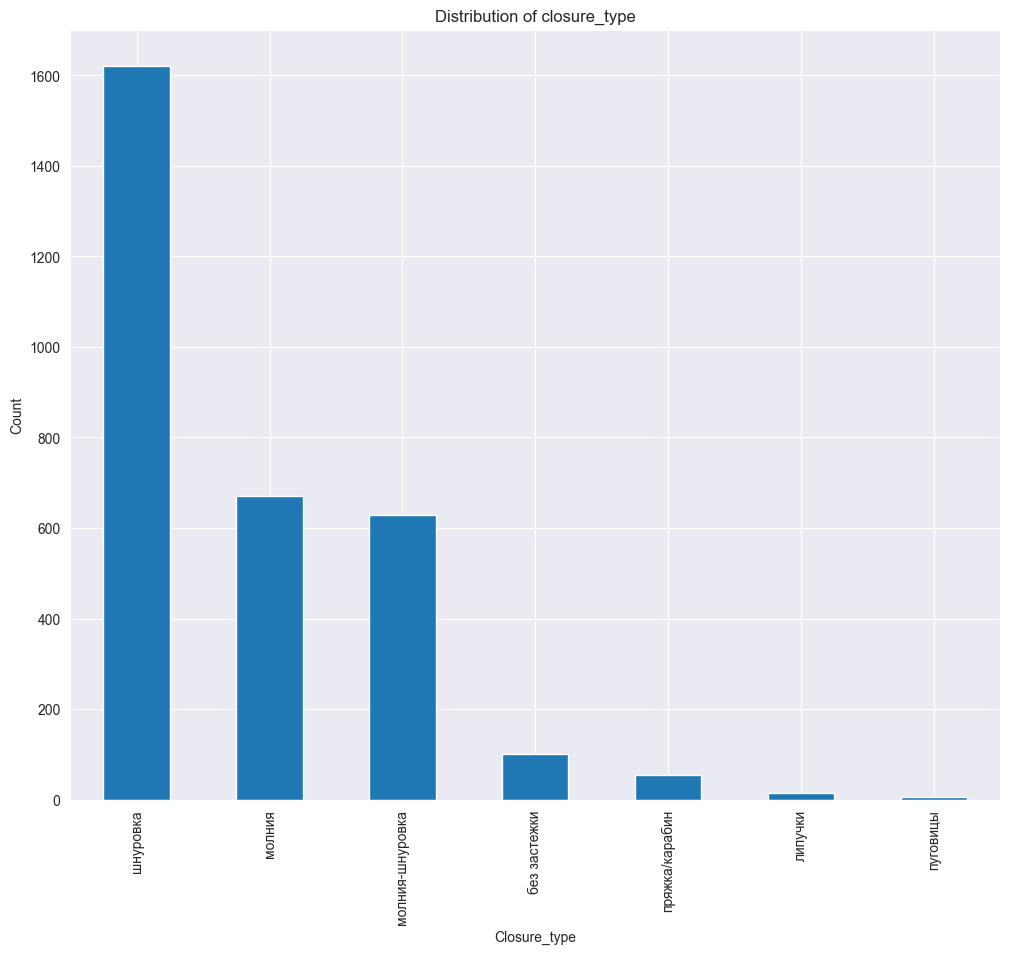

In [262]:
brand_counts = shoes['closure_type'].value_counts()

plt.figure(figsize=(12, 10))
brand_counts.plot(kind='bar')
plt.xlabel('Closure_type')
plt.ylabel('Count')
plt.title("Distribution of closure_type")

Для closure_type введем отдельную категорию other_closure_type,
куда будем помещать, если количесвто их экземпляров меньше 10

In [263]:
shoes['closure_type'] = shoes['closure_type'].apply(lambda x: x if shoes['closure_type'].value_counts()[x] > 10 else 'others_closure_type')

Text(0.5, 1.0, 'Distribution of brands')

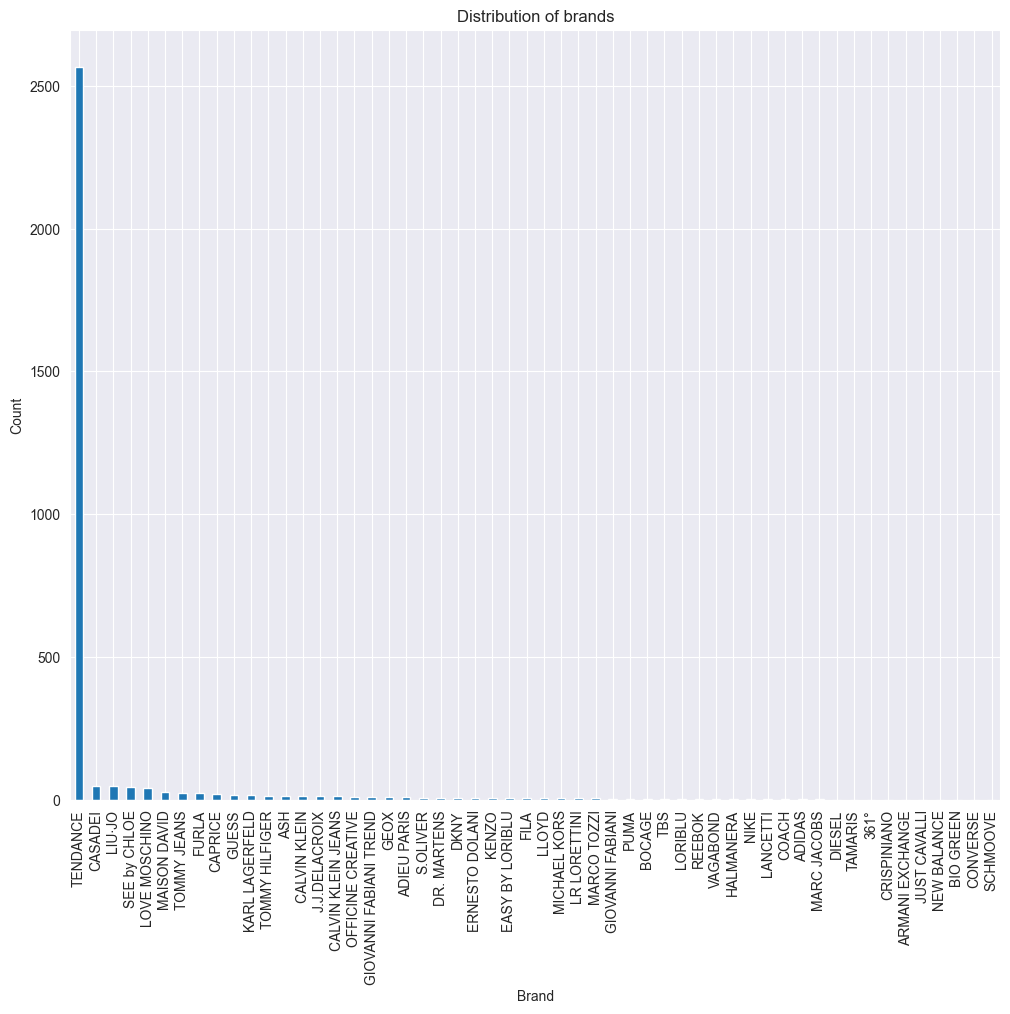

In [264]:
brand_counts = shoes['brand'].value_counts()

plt.figure(figsize=(12, 10))
brand_counts.plot(kind='bar')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title("Distribution of brands")

Для остальных редко встречающихся брендов введем отдельную категорию others_brands

In [265]:
shoes['brand'] = shoes['brand'].apply(lambda x: x if shoes['brand'].value_counts()[x] > 20 else 'others_brands')
shoes.brand.value_counts()

brand
TENDANCE         2568
others_brands     266
CASADEI            50
LIU∙JO             48
SEE by CHLOE       46
LOVE MOSCHINO      42
MAISON DAVID       26
TOMMY JEANS        24
FURLA              23
Name: count, dtype: int64

Введем новый числовой признак - populatity = rating_value * rating_count и удалим столбец rating_count

In [266]:
shoes['popularity'] = shoes['rating_count'] * shoes['rating_value']

Уберем выбросы на численных признаках, убрав 5 %

In [267]:
percentage_to_remove = 0.05
sorted_price_data = shoes.sort_values(by='price', ascending=False)
shoes = sorted_price_data.iloc[int(percentage_to_remove * len(shoes)):]
sorted_shoe_height_data = shoes.sort_values(by='shoe_height', ascending=False)
shoes = sorted_shoe_height_data.iloc[int(percentage_to_remove * len(shoes)):]
sorted_popularity_data = shoes.sort_values(by='popularity', ascending=False)
shoes = sorted_popularity_data.iloc[int(percentage_to_remove * len(shoes)):]
shoes

,brand,price,shoe_height,sole_thickness,closure_type,heel_height,rating_value,rating_count,season_spring,season_summer,...,season_winter,style_casual,style_sport,style_urban,style_glamour,style_ethnic,style_elegant,style_conceptual_art,shoes_type,popularity
1873,TENDANCE,8160,8.500000,4.0,шнуровка,0.0,5.0,42.0,1,0,...,0,1,0,0,0,0,0,0,кеды,210.0
2028,TENDANCE,7200,18.000000,5.0,молния,0.0,5.0,42.0,0,0,...,1,1,1,0,0,0,0,0,ботинки,210.0
145,TENDANCE,6990,12.000000,4.5,молния,0.0,5.0,42.0,0,0,...,1,0,1,0,0,0,0,0,others_shoes_type,210.0
486,TENDANCE,9100,6.000000,2.5,шнуровка,0.0,5.0,42.0,0,0,...,1,1,0,0,0,0,0,0,лоферы,210.0
2861,TENDANCE,5990,14.886934,1.5,пряжка/карабин,0.0,5.0,41.0,0,0,...,0,1,0,0,0,0,0,0,none,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,TENDANCE,6480,18.000000,3.7,шнуровка,0.0,1.0,2.0,1,0,...,1,1,0,0,0,0,0,0,ботинки,2.0
900,TENDANCE,7200,16.500000,3.0,шнуровка,4.7,1.0,1.0,1,0,...,1,1,0,0,0,0,0,0,ботинки,1.0
132,TOMMY JEANS,15600,17.000000,2.3,молния-шнуровка,3.7,1.0,1.0,1,0,...,1,1,0,0,0,0,0,0,ботинки,1.0
2844,TENDANCE,14290,15.000000,3.5,молния-шнуровка,5.0,1.0,1.0,0,0,...,1,1,0,0,0,0,0,0,ботинки,1.0


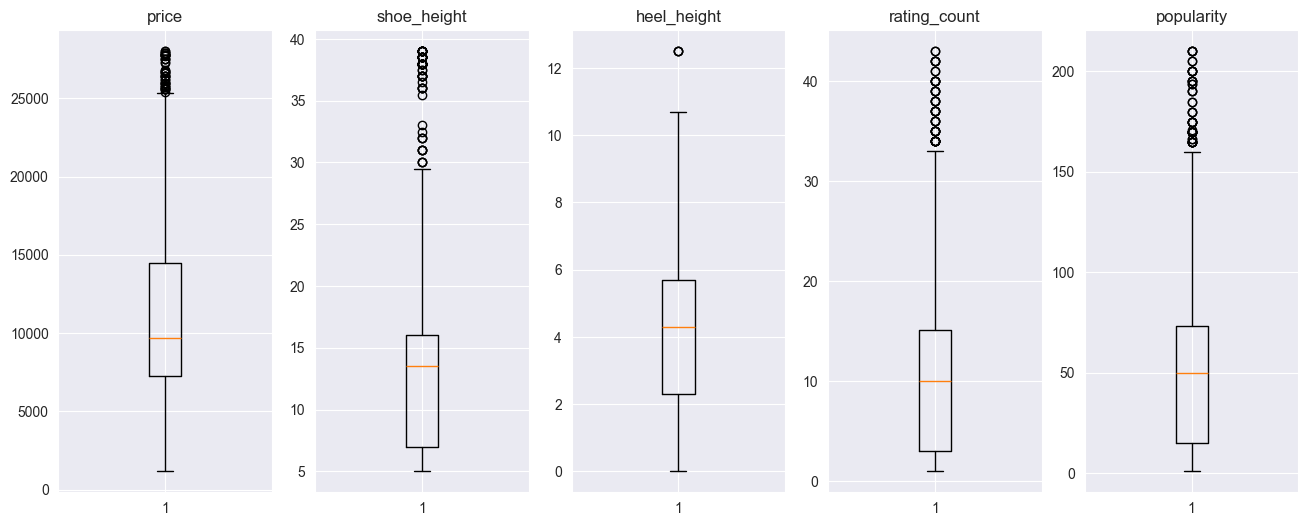

In [268]:
numeric_features = ['price', 'shoe_height', 'heel_height', 'rating_count', 'popularity']
fig, axes = plt.subplots(1, len(numeric_features), figsize=(16, 6))
for i, feature in enumerate(numeric_features):
    axes[i].boxplot(shoes[feature])
    axes[i].set_title(feature)


In [269]:
cols = list(shoes.columns.values)
cols.remove('price')
cols = ['price'] + cols
shoes = shoes[cols]

Закодируем категориальные переменные и построим матрицу корреляций для признаков.

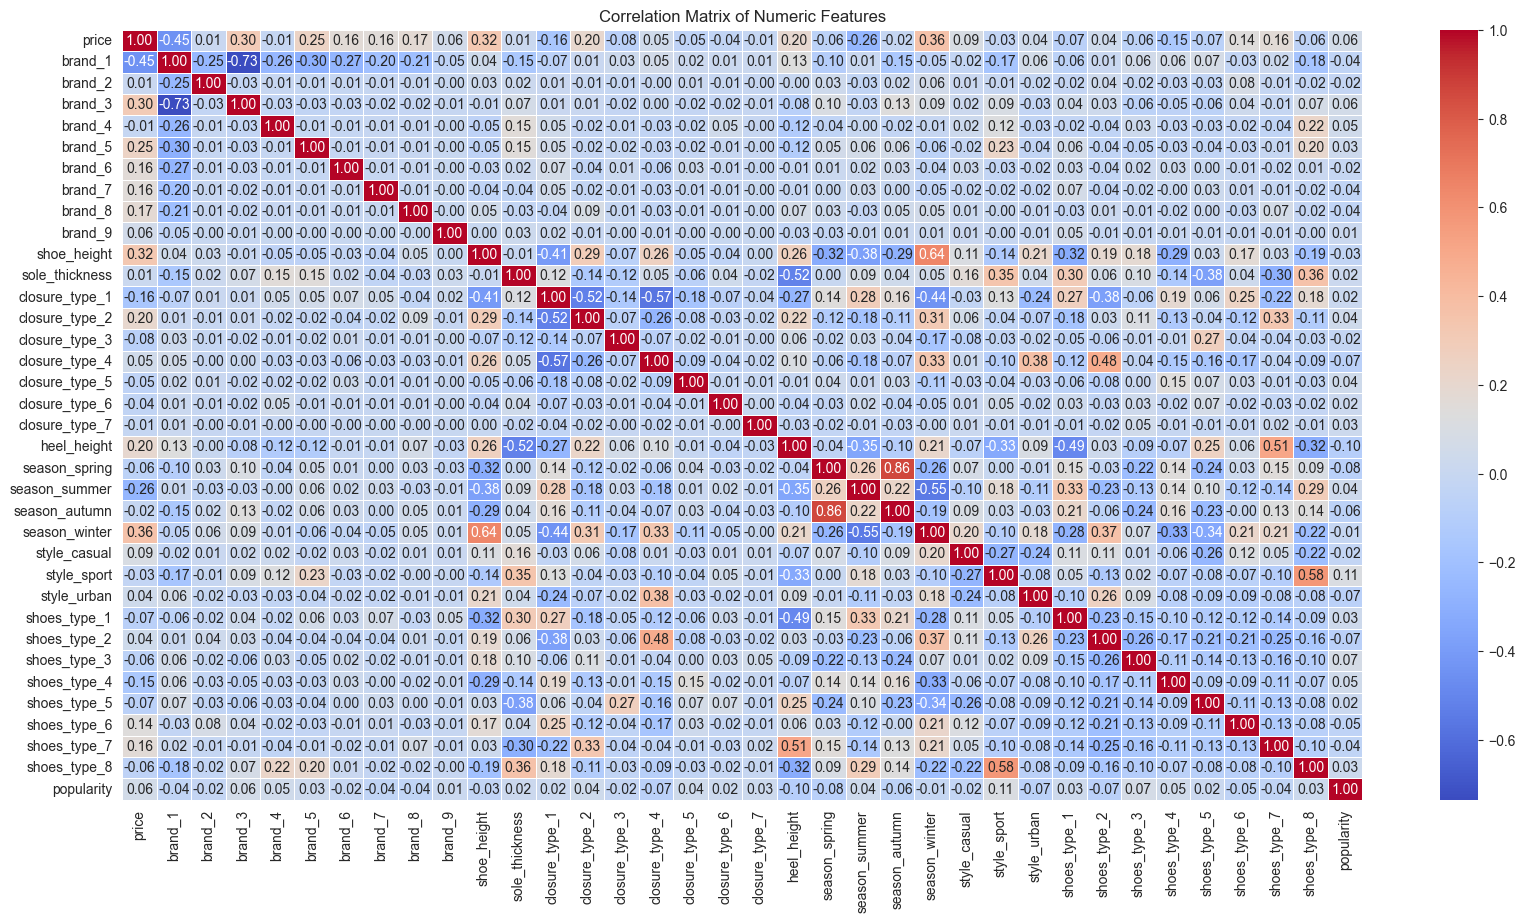

In [270]:
encoder = ce.OneHotEncoder(cols=['brand', 'closure_type', 'shoes_type'])
shoes = encoder.fit_transform(shoes)
correlation_matrix = shoes.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

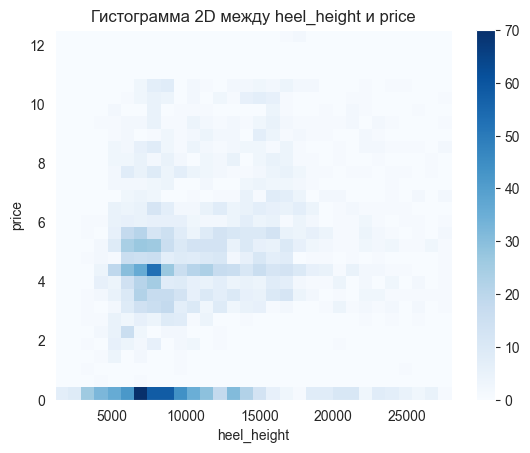

In [274]:
import matplotlib.pyplot as plt

price = shoes['price']
heel_height = shoes['heel_height']

plt.hist2d(price, heel_height, bins=(30, 30), cmap='Blues')
plt.xlabel('heel_height')
plt.ylabel('price')
plt.title('Гистограмма 2D между heel_height и price')
plt.colorbar()


In [275]:
y, shoes = shoes.price, shoes.drop(['price'], axis=1)

In [276]:
X_train, X_temp, y_train, y_temp = train_test_split(shoes, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_valid)
X_test_scaled = scaler.fit_transform(X_test)

In [277]:
class RidgeParams:
    alpha: float
    eta0: float
    max_iter: int

    def __init__(self, alpha, eta0, max_iter):
        self.alpha = alpha
        self.eta0 = eta0
        self.max_iter = max_iter

In [337]:
alphas = np.linspace(0, 10, 100)
learning_rates = [0.001, 0.01, 0.1]
max_iter_value = [100, 1000, 10000]
best_result = float('inf')
best_params = RidgeParams(alpha=0, eta0=0, max_iter=0)
for alpha in range(0, 10, 1):
    for lr in learning_rates:
        for i in max_iter_value:
            model = SGDRegressor(learning_rate='constant',
                                 eta0=lr,
                                 max_iter=i,
                                 alpha=alpha)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_valid)
            mape = mean_absolute_percentage_error(y_valid, y_pred)
            if mape < best_result:
                best_result = mape
                best_params = RidgeParams(alpha=alpha,
                                          eta0=lr,
                                          max_iter=i)
print(best_params.alpha)
print(best_params.max_iter)
print(best_params.eta0)
model = SGDRegressor(learning_rate='constant',
                     eta0=best_params.eta0,
                     max_iter=best_params.max_iter,
                     alpha=best_params.alpha)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
lib_model_mape = mean_absolute_percentage_error(y_test, y_pred)
print("Lib Model MAPE: ", lib_model_mape)

/Users/ola-stepanova/PycharmProjects/lab1/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/Users/ola-stepanova/PycharmProjects/lab1/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/Users/ola-stepanova/PycharmProjects/lab1/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/Users/ola-stepanova/PycharmProjects/lab1/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/Users/ola-stepanova/PycharmProjects/lab1/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/Users/ola-step

8
1000
0.01
Lib Model MAPE:  0.4156563428072975


/Users/ola-stepanova/PycharmProjects/lab1/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/Users/ola-stepanova/PycharmProjects/lab1/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/Users/ola-stepanova/PycharmProjects/lab1/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/Users/ola-stepanova/PycharmProjects/lab1/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/Users/ola-stepanova/PycharmProjects/lab1/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
/Users/ola-step

Выичислим MAPE на тренировочных данных для Lib Model:

In [336]:
y_pred_train = model.predict(X_train_scaled)
lib_model_mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
print("Lib model MAPE на тренировочных: ", lib_model_mape_train)

Lib model MAPE на тренировочных:  0.40472176521381314


In [284]:
class RidgeGD:
    def __init__(self, alpha, eta0, max_iter):
        self.beta_coeffs = None
        self.alpha = alpha
        self.eta0 = eta0
        self.max_iter = max_iter

    def predict(self, x):
        I_matrix = np.ones((len(x), 1))
        x = np.concatenate((I_matrix, x), axis=1)
        return np.dot(x, self.beta_coeffs)


    def fit(self, x, y):
        I_matrix = np.ones((len(x), 1))
        x = np.concatenate((I_matrix, x), axis=1)
        features_number = x.shape[1]
        self.beta_coeffs = np.zeros(features_number)
        errors = []
        for i in range(self.max_iter):
            n = len(x)
            error = y - np.dot(x, self.beta_coeffs)
            regularization = self.alpha * np.dot(self.beta_coeffs, self.beta_coeffs)
            er = regularization + np.sum(error ** 2) / (2 * n)
            errors.append(er)
            gradient = self.count_gradient(x, y, self.beta_coeffs)
            self.beta_coeffs -= self.eta0 * gradient

    def count_gradient(self, x, y, beta_coeffs):
        n = len(x)
        error = y - np.dot(x, self.beta_coeffs)
        regularization = self.alpha * beta_coeffs
        return regularization / n - np.dot(x.T, error) / n





In [340]:
alphas = np.linspace(0, 10, 100)
learning_rates = [0.001, 0.01, 0.1]
max_iter_value = [100, 1000, 10000]
best_result = float('inf')
best_params = RidgeParams(alpha=0, eta0=0, max_iter=0)
for alpha in range(0, 10, 1):
    for lr in learning_rates:
        for i in  max_iter_value:
            model = RidgeGD(alpha=alpha, max_iter=i, eta0=lr)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_valid)
            mape = mean_absolute_percentage_error(y_valid, y_pred)
            if mape < best_result:
                best_result = mape
                best_params = RidgeParams(alpha=alpha,
                                          eta0=lr,
                                          max_iter=i)
cutom_model = RidgeGD(eta0=best_params.eta0,
                max_iter=best_params.max_iter,
                alpha=8)
cutom_model.fit(X_train_scaled, y_train)
y_pred = cutom_model.predict(X_test_scaled)
custom_model_mape = mean_absolute_percentage_error(y_test, y_pred)
print("Custom model MAPE на тестовых данных: ", custom_model_mape)

Custom model MAPE на тестовых данных:  0.3815566400359545


Вычилим MAPE на тренировочных данных для Custom Model:

In [344]:
y_pred_train = cutom_model.predict(X_train_scaled)
custom_model_mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
print("Custom model MAPE на тренировочных: ", custom_model_mape_train)

Custom model MAPE на тренировочных:  0.38256188706429745


Сравним метрики MAPE на тесте:

In [343]:
print("Custom model MAPE: ", custom_model_mape)
print("Lib Model MAPE: ", lib_model_mape)
print("Difference: " ,abs(lib_model_mape - custom_model_mape))

Custom model MAPE:  0.3815566400359545
Lib Model MAPE:  0.4156563428072975
Difference:  0.034099702771343


Выведем все в одной ячейке. Метрики не сильно отличаются - модель не переобучена

In [314]:
print("Custom model MAPE на тесте: ", custom_model_mape)
print("Lib Model MAPE на тесте: ", lib_model_mape)
print("Difference на тесте: " ,abs(lib_model_mape - custom_model_mape))
print("Custom model MAPE на тренировочных: ", custom_model_mape_train)
print("Lib model MAPE на тренировочных: ", lib_model_mape_train)
print("Difference на тренировочных: " ,abs(custom_model_mape_train - lib_model_mape_train))

Custom model MAPE на тесте:  0.3814704216507962
Lib Model MAPE на тесте:  0.37410934596099477
Difference на тесте:  0.007361075689801433
Custom model MAPE на тренировочных:  0.3824846004795315
Lib model MAPE на тренировочных:  0.39697457571447553
Difference на тренировочных:  0.014489975234944052
